# Sentiment analysis tutorial

following https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-

In [40]:
# general imports
import numpy as np
import pandas as pd
import tweepy
from textblob import TextBlob
import re

# plotting and visualization
import matplotlib
#matplotlib.use("agg")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(matplotlib.get_backend())

from credentials import *   # import API key and access key and token without being seen by the app


module://ipykernel.pylab.backend_inline


In [41]:
def twitter_setup():
    """
    Utility function to setup the Twitter's API with our
    access keys provided
    """
    # authentication and access using keys
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # return API with authentication
    api = tweepy.API(auth)
    return api


def twitter_tweets(api, screen_name="realDonaldTrump"):
    """
    create a tweets extractor that collects tweets from a 
    screen_name.
    """

    # create a tweet list
    tweets = api.user_timeline(screen_name=screen_name, count=200)
    print("extracting tweets for user {}".format(screen_name))
    print("Number of tweets extracted: {}.\n".format(len(tweets)))

    # print the most recent five tweets
    [ print(tweet.text) for tweet in tweets[:5] ]
    print()

    # create a pandas df from tweets
    S2 = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

    # display the first 10 elements of the df
    #print(S2.head(10))

    # internal methods of a single tweet object
    #print(dir(tweets[0]))

    # adding tweet metadata
    S2['len'] = np.array([len(tweet.text) for tweet in tweets])
    S2['ID'] = np.array([tweet.id for tweet in tweets])
    S2['Date'] = np.array([tweet.created_at for tweet in tweets])
    S2['Source'] = np.array([tweet.source for tweet in tweets])
    S2['Likes'] = np.array([tweet.favorite_count for tweet in tweets])
    S2['RTs'] = np.array([tweet.retweet_count for tweet in tweets])

    print(S2.head(10))

    # mean of lengths
    mean = np.mean(S2['len'])
    print("The average length in tweets: {}".format(mean))

    # max favorites and Retweets
    fav_max = np.max(S2['Likes'])
    rt_max = np.max(S2['RTs'])

    fav = S2[S2['Likes'] == fav_max].index[0]
    rt = S2[S2['RTs'] == rt_max].index[0]

    print("The tweet with the most ({}) likes is: {}".format(fav_max, S2['Tweets'][fav]))
    print("The tweet with the most ({}) retweets is: {}".format(rt_max, S2['Tweets'][rt]))

    return S2


def twitter_time_series_plots(S2):
    # create time series data

    tlen = pd.Series(data=S2['len'].values, index=S2['Date'])
    tfav = pd.Series(data=S2['Likes'].values, index=S2['Date'])
    tret = pd.Series(data=S2['RTs'].values, index=S2['Date'])

    # plot lengths of tweets
    tlen.plot(figsize=(16,4), color='r')
    plt.show()

    # plot likes and retweets
    tfav.plot(figsize=(16,4), label="Likes", legend=True)
    tret.plot(figsize=(16,4), label="Retweets", legend=True)
    plt.show()
    
    # plot sources in a pie chart
    sources = []
    for source in S2['Source']:
        if source not in sources:
            sources.append(source)

    print("create of content sources:")
    [ print("* {}".format(source)) for source in sources ]

    # count number of sources
    percent = np.zeros(len(sources))

    for source in S2['Source']:
        for index in range(len(sources)):
            if source == sources[index]:
                percent[index] += 1
                pass

    percent /= 100

    pie_chart = pd.Series(percent, index=sources, name='Sources')
    pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6,6))
    plt.show()
    

def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    
    textblob already has a trained analyser to work 
    with different machine learning models on 
    natural language processing.
    
    Might want to train our own model
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    

def sentiment_analysis(S2):
    # We create a column with the result of the analysis:
    S2['SA'] = np.array([ analize_sentiment(tweet) for tweet in S2['Tweets'] ])
    
    # We construct lists with classified tweets:
    pos_tweets = [ tweet for index, tweet in enumerate(S2['Tweets']) if S2['SA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(S2['Tweets']) if S2['SA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(S2['Tweets']) if S2['SA'][index] < 0]

    # We print percentages:
    print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(S2['Tweets'])))
    print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(S2['Tweets'])))
    print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(S2['Tweets'])))

## Generate an API

In [42]:
# create an extractor object to get quantity of tweets from screen_name
api = twitter_setup()

## Build a dataframe

In [59]:
S2 = twitter_tweets(api)

extracting tweets for user realDonaldTrump
Number of tweets extracted: 200.

Just landed in West Virginia. Big crowd, looking forward to seeing everyone soon! #MAGA
Join me tonight at the Charleston Civic Center in West Virginia at 7:00pmE! Tickets: https://t.co/OX8gGhdmg9
To the incredible people of the Great State of Wyoming: Go VOTE TODAY for Foster Friess - He will be a fantastic Go… https://t.co/8GCuYKYjlb
Bill DeBlasio, the high taxing Mayor of NYC, just stole my campaign slogan: PROMISES MADE  PROMISES KEPT! That’s no… https://t.co/waf360rhmh
Big Rally tonight in West Virginia. Patrick Morrisey is running a GREAT race for U.S. Senate. I have done so much f… https://t.co/YmMc53i42q

                                              Tweets  len  \
0  Just landed in West Virginia. Big crowd, looki...   87   
1  Join me tonight at the Charleston Civic Center...  108   
2  To the incredible people of the Great State of...  140   
3  Bill DeBlasio, the high taxing Mayor of NYC, j...  140 

## Draw some graphs

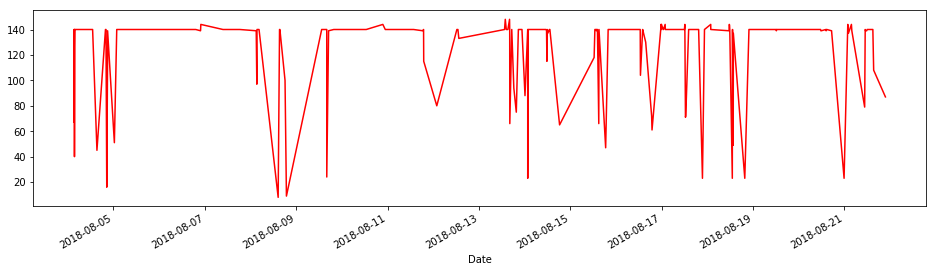

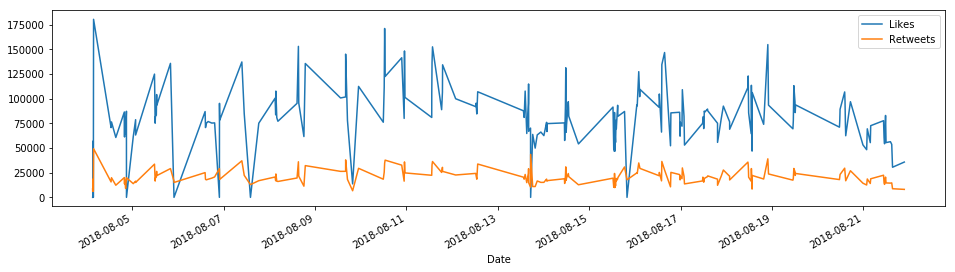

create of content sources:
* Twitter for iPhone
* Twitter for iPad


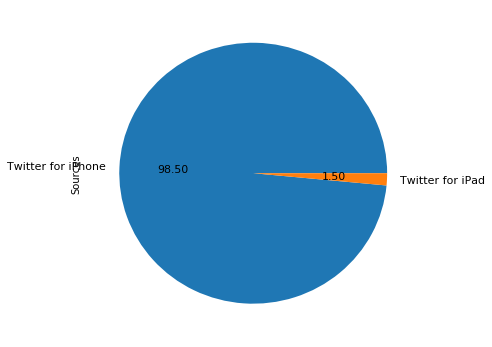

In [60]:
twitter_time_series_plots(S2)

## Sentiment analysis

In [61]:
sentiment_analysis(S2)

Percentage of positive tweets: 52.0%
Percentage of neutral tweets: 23.0%
Percentage de negative tweets: 25.0%


### twitter limits

Twitter has limits on number of api calls that can be made in an hour.

user_timeline is limited to 900/hr

In [62]:
api.rate_limit_status()

{'rate_limit_context': {'access_token': '703298479339257856-bqkN8DY2kxps8BRlQgNt7Ip5fAPUEn2'},
 'resources': {'lists': {'/lists/list': {'limit': 15,
    'remaining': 15,
    'reset': 1534895798},
   '/lists/memberships': {'limit': 75, 'remaining': 75, 'reset': 1534895798},
   '/lists/subscribers/show': {'limit': 15,
    'remaining': 15,
    'reset': 1534895798},
   '/lists/members': {'limit': 900, 'remaining': 900, 'reset': 1534895798},
   '/lists/subscriptions': {'limit': 15, 'remaining': 15, 'reset': 1534895798},
   '/lists/show': {'limit': 75, 'remaining': 75, 'reset': 1534895798},
   '/lists/ownerships': {'limit': 15, 'remaining': 15, 'reset': 1534895798},
   '/lists/subscribers': {'limit': 180, 'remaining': 180, 'reset': 1534895798},
   '/lists/members/show': {'limit': 15, 'remaining': 15, 'reset': 1534895798},
   '/lists/statuses': {'limit': 900, 'remaining': 900, 'reset': 1534895798}},
  'application': {'/application/rate_limit_status': {'limit': 180,
    'remaining': 164,
    '

In [63]:
print(api.rate_limit_status()['resources']['application'])
print(api.rate_limit_status()['resources']['statuses']['/statuses/user_timeline'])

{'/application/rate_limit_status': {'limit': 180, 'remaining': 163, 'reset': 1534895275}}
{'limit': 900, 'remaining': 898, 'reset': 1534895775}
